In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
dataset = load_dataset("trec")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [4]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'coarse_label' : train_dataset['coarse_label']})
test_df = pd.DataFrame({'text' : test_dataset['text'], 'coarse_label' : test_dataset['coarse_label']})

In [5]:
train_df.head()

,text,coarse_label
0,How did serfdom develop in and then leave Russ...,2
1,What films featured the character Popeye Doyle ?,1
2,How can I find a list of celebrities ' real na...,2
3,What fowl grabs the spotlight after the Chines...,1
4,What is the full form of .com ?,0


In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['coarse_label'])

In [7]:
initial_labeled_set

,text,coarse_label
1200,What mountainous region of the world is the Lh...,4
1066,How many acres in a mile ?,5
2927,Which Latin American country is the largest ?,4
5274,What was the Long March in China ?,2
4603,What 12-hour cold medicine uses the formula ``...,1
...,...,...
2270,In which state are the Mark Twain National For...,4
4877,What is Remembrance Day all about ?,2
4697,How many people died on South Carolina highway...,5
3178,What country will hit the year 2 first ?,4


# Spliting Data into train_encodings, test_encodings

In [8]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [9]:
train_encodings = tokenizer(initial_labeled_set['text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.coarse_label.to_list()
test_labels = test_df.coarse_label.to_list()

In [10]:
num_labels = 6
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [12]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
)

In [13]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [14]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [15]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [16]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [17]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [19]:
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 0.166 


## An Active Learning Approach Based On Uncertain Sampling

In [20]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,text,coarse_label
1200,What mountainous region of the world is the Lh...,4
1066,How many acres in a mile ?,5
2927,Which Latin American country is the largest ?,4
5274,What was the Long March in China ?,2
4603,What 12-hour cold medicine uses the formula ``...,1


In [21]:
initial_labeled_set.shape

(272, 2)

# 

In [22]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [25]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.coarse_label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'text' : data['text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['coarse_label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [27]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(10):
    
    sample_data = data.sample(n=10,random_state=42)
    data.drop(sample_data.index,inplace = True)
    entropy_prob_df = predict_and_calculate_entropy(sample_data)

    #Let now apply active learning
    text_encoding = tokenizer(entropy_prob_df['text'].to_list(),truncation=True,padding=True)
    sample_dataloader = DataLoader(test_encodings, entropy_prob_df.coarse_label.to_list())

    #test_df 
    test_encodings = tokenizer(test_df['text'].to_list(),truncation=True,padding=True)
    test_dataloader = DataLoader(test_encodings, test_df.coarse_label.to_list())

    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= train_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    n += 10

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



    
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 1.639, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 1.4216967821121216, 'eval_Accuracy': 0.494, 'eval_F1': 0.3928242199506154, 'eval_Precision': 0.8155933619196695, 'eval_Recall': 0.41822098403844254, 'eval_runtime': 0.9826, 'eval_samples_per_second': 508.847, 'eval_steps_per_second': 16.283, 'epoch': 2.94}
{'train_runtime': 9.6721, 'train_samples_per_second': 84.366, 'train_steps_per_second': 5.273, 'train_loss': 1.634072268710417, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 1.1282, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.9728456139564514, 'eval_Accuracy': 0.776, 'eval_F1': 0.6652806570502763, 'eval_Precision': 0.8646894643024674, 'eval_Recall': 0.6639549247999762, 'eval_runtime': 0.9827, 'eval_samples_per_second': 508.828, 'eval_steps_per_second': 16.282, 'epoch': 2.94}
{'train_runtime': 9.6811, 'train_samples_per_second': 84.288, 'train_steps_per_second': 5.268, 'train_loss': 1.1224161912413204, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.5741, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.6629984378814697, 'eval_Accuracy': 0.81, 'eval_F1': 0.6949725785794659, 'eval_Precision': 0.8739544710725279, 'eval_Recall': 0.705319266070628, 'eval_runtime': 0.9806, 'eval_samples_per_second': 509.879, 'eval_steps_per_second': 16.316, 'epoch': 2.94}
{'train_runtime': 9.6827, 'train_samples_per_second': 84.274, 'train_steps_per_second': 5.267, 'train_loss': 0.569771914505491, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.1744, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.9743455648422241, 'eval_Accuracy': 0.726, 'eval_F1': 0.6274641947593117, 'eval_Precision': 0.8429173037639096, 'eval_Recall': 0.655110870783338, 'eval_runtime': 0.975, 'eval_samples_per_second': 512.843, 'eval_steps_per_second': 16.411, 'epoch': 2.94}
{'train_runtime': 9.8075, 'train_samples_per_second': 83.202, 'train_steps_per_second': 5.2, 'train_loss': 0.1735630637290431, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0528, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.6855534911155701, 'eval_Accuracy': 0.814, 'eval_F1': 0.7291367924945215, 'eval_Precision': 0.877298100943694, 'eval_Recall': 0.731212818960789, 'eval_runtime': 0.965, 'eval_samples_per_second': 518.126, 'eval_steps_per_second': 16.58, 'epoch': 2.94}
{'train_runtime': 9.6236, 'train_samples_per_second': 84.791, 'train_steps_per_second': 5.299, 'train_loss': 0.05249164531043932, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0191, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5756201148033142, 'eval_Accuracy': 0.858, 'eval_F1': 0.729221162492612, 'eval_Precision': 0.8962287152029932, 'eval_Recall': 0.739684832171213, 'eval_runtime': 0.9649, 'eval_samples_per_second': 518.178, 'eval_steps_per_second': 16.582, 'epoch': 2.94}
{'train_runtime': 9.6363, 'train_samples_per_second': 84.68, 'train_steps_per_second': 5.292, 'train_loss': 0.018874393922148968, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0107, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4611596167087555, 'eval_Accuracy': 0.908, 'eval_F1': 0.867510433934957, 'eval_Precision': 0.9098252718796013, 'eval_Recall': 0.8459475901252927, 'eval_runtime': 0.9719, 'eval_samples_per_second': 514.456, 'eval_steps_per_second': 16.463, 'epoch': 2.94}
{'train_runtime': 9.6407, 'train_samples_per_second': 84.641, 'train_steps_per_second': 5.29, 'train_loss': 0.010557608331973646, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0036, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.47675150632858276, 'eval_Accuracy': 0.908, 'eval_F1': 0.8926915539130037, 'eval_Precision': 0.9294088722172195, 'eval_Recall': 0.8714286378257426, 'eval_runtime': 0.9759, 'eval_samples_per_second': 512.358, 'eval_steps_per_second': 16.395, 'epoch': 2.94}
{'train_runtime': 9.6398, 'train_samples_per_second': 84.649, 'train_steps_per_second': 5.291, 'train_loss': 0.0035955255951586307, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0016, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.46972447633743286, 'eval_Accuracy': 0.92, 'eval_F1': 0.890672389520886, 'eval_Precision': 0.9165250405275575, 'eval_Recall': 0.8722519335588373, 'eval_runtime': 0.9681, 'eval_samples_per_second': 516.5, 'eval_steps_per_second': 16.528, 'epoch': 2.94}
{'train_runtime': 9.6431, 'train_samples_per_second': 84.62, 'train_steps_per_second': 5.289, 'train_loss': 0.0015557863813477988, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

{'loss': 0.0006, 'learning_rate': 2.5e-05, 'epoch': 2.94}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.49248242378234863, 'eval_Accuracy': 0.92, 'eval_F1': 0.8530576145079117, 'eval_Precision': 0.939355881294427, 'eval_Recall': 0.8242806145164936, 'eval_runtime': 0.976, 'eval_samples_per_second': 512.292, 'eval_steps_per_second': 16.393, 'epoch': 2.94}
{'train_runtime': 9.655, 'train_samples_per_second': 84.516, 'train_steps_per_second': 5.282, 'train_loss': 0.0006095839449770603, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

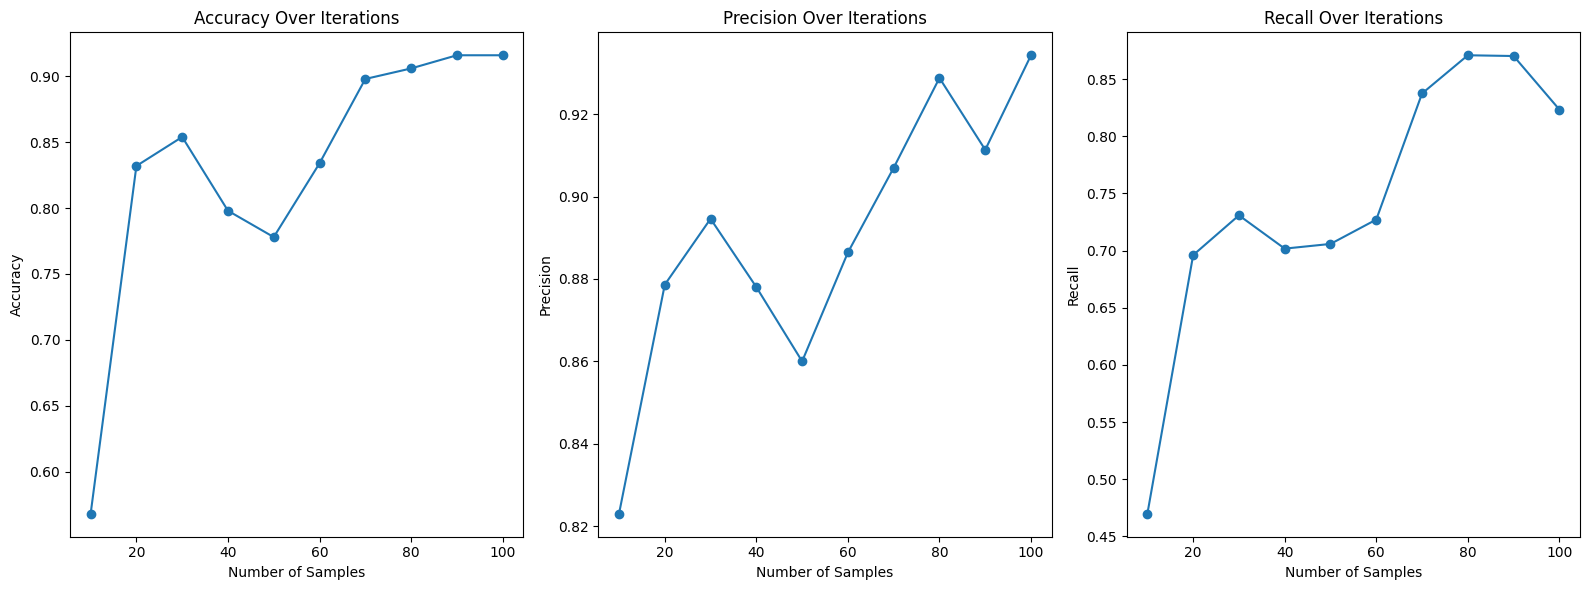

In [28]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [30]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/16 [00:00<?, ?it/s]

accuracy 92.0% 


# Confusion Matrix